In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import HTML,display
import PIL
from PIL import Image
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import cv2
import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
class PngDataset():
    def __init__(self, images_list, masks_list, transform=None):
        self.images = images_list
        self.masks = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path).convert("L")
        mask = nib.load(mask_path).get_fdata()
        # Convert PIL Image to numpy array
        image = np.array(image)
        # Add channel dimension (making it 1 x height x width)
        image = np.expand_dims(image, axis=0)
        # Convert numpy arrays to PyTorch tensors
        image = torch.from_numpy(image).float()

        # Apply the transformations to the mask
        mask = np.rot90(mask)
        mask = np.flipud(mask)
        mask = torch.from_numpy(mask).float()
        mask = mask.permute(2,0,1)


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask, image_path, mask_path

In [ ]:
image_dir = "/Users/owner/Desktop/AI NYU Langone/raw2/Images"
mask_dir = "/Users/owner/Desktop/AI NYU Langone/raw2/Masks"

# Lists of image and mask paths
image_data_path_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])[:44]
mask_data_path_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii.gz')])[:44]

# Define the target size
target_size = (150, 45)

# Define directories
modified_image_dir = "/Users/owner/Desktop/AI NYU Langone/Train/Images"
modified_mask_dir = "/Users/owner/Desktop/AI NYU Langone/Train/Masks"

# Create directories if they do not exist
os.makedirs(modified_image_dir, exist_ok=True)
os.makedirs(modified_mask_dir, exist_ok=True)

# Loop through image paths and modify them
for image_path in image_data_path_list:
    # Load the image
    image = Image.open(image_path).convert("L")
    # Resize the image
    resized_image = image.resize(target_size, Image.ANTIALIAS)
    # Save the modified image
    new_image_path = os.path.join(modified_image_dir, os.path.basename(image_path))
    resized_image.save(new_image_path)

# Loop through mask paths and modify them
for mask_path in mask_data_path_list:
    # Load the mask
    mask = nib.load(mask_path).get_fdata()
    # Resize each slice in the mask
    modified_mask = np.array([cv2.resize(slice, target_size, interpolation=cv2.INTER_NEAREST) for slice in mask])
    # Save the modified mask
    new_mask_path = os.path.join(modified_mask_dir, os.path.basename(mask_path))
    nib.save(nib.Nifti1Image(modified_mask, np.eye(4)), new_mask_path)

In [ ]:
# Lists of modified image and mask paths
modified_image_data_path_list = sorted([os.path.join(modified_image_dir, f) for f in os.listdir(modified_image_dir) if f.endswith('.tif')])
modified_mask_data_path_list = sorted([os.path.join(modified_mask_dir, f) for f in os.listdir(modified_mask_dir) if f.endswith('.nii.gz')])

In [ ]:
# Instantiate the dataset using the truncated lists
dataset = PngDataset(images_list= modified_image_data_path_list, masks_list= modified_mask_data_path_list)

In [ ]:
mask_path = "/Users/owner/Desktop/AI NYU Langone/Train/Masks"
png_mask_dir = "/Users/owner/Desktop/AI NYU Langone/Train/Masks_png/"

for i in range(44):
    _, mask, _, mask_path = dataset[i]

    # Convert the mask slice to uint8 (if it is not already)
    mask_slice = (mask[0].squeeze().numpy() * 255).astype(np.uint8)

    # Define the path to save the PNG image
    png_mask_path = os.path.join(png_mask_dir, os.path.basename(mask_path).replace('.nii.gz', '.png'))

    # Save the mask slice as a PNG image
    cv2.imwrite(png_mask_path, mask_slice)

torch.Size([150, 45, 150])
torch.Size([1, 45, 150])


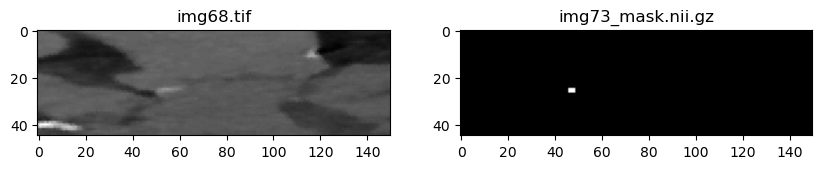

In [ ]:
image, mask, image_path, mask_path = dataset[43]
print(mask.shape)
print(image.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap = "gray")
ax[0].set_title(os.path.basename(image_path))
ax[1].imshow(mask[0].squeeze(), cmap = "gray")
ax[1].set_title(os.path.basename(mask_path))
plt.show()